# Caffe2 Basic Concepts - Operators & Nets

In this tutorial we will go through a set of Caffe2 basics: the basic concepts including how operators and nets are being written.

First, let's import Caffe2. `core` and `workspace` are usually the two that you need most. If you want to manipulate protocol buffers generated by Caffe2, you probably also want to import `caffe2_pb2` from `caffe2.proto`.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# We'll also import a few standard python libraries
from matplotlib import pyplot
import numpy as np
import time

# These are the droids you are looking for.
from caffe2.python import core, workspace
from caffe2.proto import caffe2_pb2

# Let's show all plots inline.
%matplotlib inline

You might see a warning saying that caffe2 does not have GPU support. That means you are running a CPU-only build. Don't be alarmed - anything CPU is still runnable without a problem.

## Workspaces

Let's cover workspaces first, where all the data resides.

Similar to Matlab, the Caffe2 workspace consists of blobs you create and store in memory. For now, consider a blob to be a N-dimensional Tensor similar to numpy's ndarray, but contiguous. Down the road, we will show you that a blob is actually a typed pointer that can store any type of C++ objects, but Tensor is the most common type stored in a blob. Let's show what the interface looks like.

`Blobs()` prints out all existing blobs in the workspace. 
`HasBlob()` queries if a blob exists in the workspace. As of now, we don't have any.

In [2]:
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
print("Workspace has blob 'X'? {}".format(workspace.HasBlob("X")))

Current blobs in the workspace: []
Workspace has blob 'X'? False


We can feed blobs into the workspace using `FeedBlob()`.

In [3]:
X = np.random.randn(2, 3).astype(np.float32)
print("Generated X from numpy:\n{}".format(X))
workspace.FeedBlob("X", X)

Generated X from numpy:
[[ 1.0922441  -0.65129787 -0.2511869 ]
 [ 1.3999398  -0.86516035 -2.0602188 ]]


True

Now, let's take a look at what blobs are in the workspace.

In [4]:
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
print("Workspace has blob 'X'? {}".format(workspace.HasBlob("X")))
print("Fetched X:\n{}".format(workspace.FetchBlob("X")))

Current blobs in the workspace: [u'X']
Workspace has blob 'X'? True
Fetched X:
[[ 1.0922441  -0.65129787 -0.2511869 ]
 [ 1.3999398  -0.86516035 -2.0602188 ]]


Let's verify that the arrays are equal.

In [5]:
np.testing.assert_array_equal(X, workspace.FetchBlob("X"))

Note that if you try to access a blob that does not exist, an error will be thrown:

In [6]:
try:
    workspace.FetchBlob("invincible_pink_unicorn")
except RuntimeError as err:
    print(err)

[enforce fail at pybind_state.cc:173] ws->HasBlob(name). Can't find blob: invincible_pink_unicorn 


One thing that you might not use immediately: you can have multiple workspaces in Python using different names, and switch between them. Blobs in different workspaces are separate from each other. You can query the current workspace using `CurrentWorkspace`. Let's try switching the workspace by name (gutentag) and creating a new one if it doesn't exist.

In [7]:
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

# Switch the workspace. The second argument "True" means creating 
# the workspace if it is missing.
workspace.SwitchWorkspace("gutentag", True)

# Let's print the current workspace. Note that there is nothing in the
# workspace yet.
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

Current workspace: default
Current blobs in the workspace: [u'X']
Current workspace: gutentag
Current blobs in the workspace: []


Let's switch back to the default workspace.

In [8]:
workspace.SwitchWorkspace("default")
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

Current workspace: default
Current blobs in the workspace: [u'X']


Finally, `ResetWorkspace()` clears anything that is in the current workspace.

In [9]:
workspace.ResetWorkspace()
print("Current blobs in the workspace after reset: {}".format(workspace.Blobs()))

Current blobs in the workspace after reset: []


## Operators

Operators in Caffe2 are kind of like functions. From the C++ side, they all derive from a common interface, and are registered by type, so that we can call different operators during runtime. The interface of operators is defined in `caffe2/proto/caffe2.proto`. Basically, it takes in a bunch of inputs, and produces a bunch of outputs.

Remember, when we say "create an operator" in Caffe2 Python, nothing gets run yet. All it does is create the protocol buffer that specifies what the operator should be. At a later time it will be sent to the C++ backend for execution. If you are not familiar with protobuf, it is a json-like serialization tool for structured data. Find more about protocol buffers [here](https://developers.google.com/protocol-buffers/).

Let's see an actual example.

In [10]:
# Create an operator.
op = core.CreateOperator(
    "Relu", # The type of operator that we want to run
    ["X"], # A list of input blobs by their names
    ["Y"], # A list of output blobs by their names
)
# and we are done!

As we mentioned, the created op is actually a protobuf object. Let's show the content.

In [11]:
print("Type of the created op is: {}".format(type(op)))
print("Content:\n")
print(str(op))

Type of the created op is: <class 'caffe2.proto.caffe2_pb2.OperatorDef'>
Content:

input: "X"
output: "Y"
name: ""
type: "Relu"



Ok, let's run the operator. We first feed the input X to the workspace. 
Then the simplest way to run an operator is to do `workspace.RunOperatorOnce(operator)`

In [12]:
workspace.FeedBlob("X", np.random.randn(2, 3).astype(np.float32))
workspace.RunOperatorOnce(op)

True

After execution, let's see if the operator is doing the right thing.

In this case, the operator is a common activation function used in neural networks, called [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), or Rectified Linear Unit activation. ReLU activation helps to add necessary non-linear characteristics to the neural network classifier, and is defined as:

$$ReLU(x) = max(0, x)$$

In [13]:
print("Current blobs in the workspace: {}\n".format(workspace.Blobs()))
print("X:\n{}\n".format(workspace.FetchBlob("X")))
print("Y:\n{}\n".format(workspace.FetchBlob("Y")))
print("Expected:\n{}\n".format(np.maximum(workspace.FetchBlob("X"), 0)))

Current blobs in the workspace: [u'X', u'Y']

X:
[[-0.958609   -1.5830146  -1.1998546 ]
 [ 0.77405983  0.08448339  0.57201284]]

Y:
[[0.         0.         0.        ]
 [0.77405983 0.08448339 0.57201284]]

Expected:
[[0.         0.         0.        ]
 [0.77405983 0.08448339 0.57201284]]



This is working if your Expected output matches your Y output in this example.

Operators also take optional arguments if needed. They are specified as key-value pairs. Let's take a look at one simple example, which takes a tensor and fills it with Gaussian random variables.

In [14]:
op = core.CreateOperator(
    "GaussianFill",
    [], # GaussianFill does not need any parameters.
    ["Z"],
    shape=[100, 100], # shape argument as a list of ints.
    mean=1.0,  # mean as a single float
    std=1.0, # std as a single float
)
print("Content of op:\n")
print(str(op))

Content of op:

output: "Z"
name: ""
type: "GaussianFill"
arg {
  name: "std"
  f: 1.0
}
arg {
  name: "shape"
  ints: 100
  ints: 100
}
arg {
  name: "mean"
  f: 1.0
}



Let's run it and see if things are as intended.

Text(0.5,1,u'Distribution of Z')

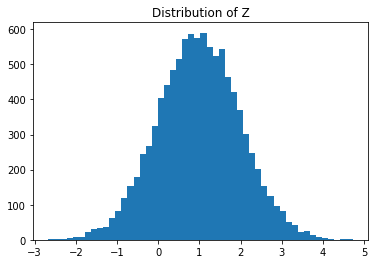

In [15]:
workspace.RunOperatorOnce(op)
temp = workspace.FetchBlob("Z")
pyplot.hist(temp.flatten(), bins=50)
pyplot.title("Distribution of Z")

If you see a bell shaped curve then it worked!

## Nets

Nets are essentially computation graphs. We keep the name `Net` for backward consistency (and also to pay tribute to neural nets). A Net is composed of multiple operators just like a program written as a sequence of commands. Let's take a look.

When we talk about nets, we will also talk about BlobReference, which is an object that wraps around a string so we can do easy chaining of operators.

Let's create a network that is essentially the equivalent of the following python math:
```
X = np.random.randn(2, 3)
W = np.random.randn(5, 3)
b = np.ones(5)
Y = X * W^T + b
```
We'll show the progress step by step. Caffe2's `core.Net` is a wrapper class around a NetDef protocol buffer.

When creating a network, its underlying protocol buffer is essentially empty other than the network name. Let's create the net and then show the proto content.

In [16]:
net = core.Net("my_first_net")
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net"



Let's create a blob called X, and use GaussianFill to fill it with some random data.

In [17]:
X = net.GaussianFill([], ["X"], mean=0.0, std=1.0, shape=[2, 3], run_once=0)
print("New network proto:\n\n{}".format(net.Proto()))

New network proto:

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}



You might have observed a few differences from the earlier `core.CreateOperator` call. Basically, when using a net, you can directly create an operator *and* add it to the net at the same time by calling `net.SomeOp` where SomeOp is a registered type string of an operator. This gets translated to
```
op = core.CreateOperator("SomeOp", ...)
net.Proto().op.append(op)
```

Also, you might be wondering what X is. X is a `BlobReference` which records two things:

- The blob's name, which is accessed with `str(X)`

- The net it got created from, which is recorded by the internal variable `_from_net`

Let's verify it. Also, remember, we are not actually running anything yet, so X contains nothing but a symbol. Don't expect to get any numerical values out of it right now :)

In [18]:
print("Type of X is: {}".format(type(X)))
print("The blob name is: {}".format(str(X)))

Type of X is: <class 'caffe2.python.core.BlobReference'>
The blob name is: X


Let's continue to create W and b.

In [19]:
W = net.GaussianFill([], ["W"], mean=0.0, std=1.0, shape=[5, 3], run_once=0)
b = net.ConstantFill([], ["b"], shape=[5,], value=1.0, run_once=0)

Now, one simple code sugar: since the BlobReference objects know what net it is generated from, in addition to creating operators from net, you can also create operators from BlobReferences. Let's create the FC operator in this way.

In [20]:
Y = X.FC([W, b], ["Y"])

Under the hood, `X.FC(...)` simply delegates to `net.FC` by inserting `X` as the first input of the corresponding operator, so what we did above is equivalent to
```
Y = net.FC([X, W, b], ["Y"])
```

Let's take a look at the current network.

In [21]:
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



Too verbose huh? Let's try to visualize it as a graph. Caffe2 ships with a very minimal graph visualization tool for this purpose.

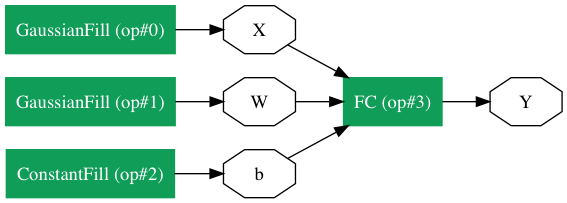

In [22]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(net, rankdir="LR")
display.Image(graph.create_png(), width=800)

So we have defined a Net, but nothing has been executed yet. Remember that the net above is essentially a protobuf that holds the definition of the network. When we actually run the network, what happens under the hood is:
- A C++ net object is instantiated from the protobuf
- The instantiated net's Run() function is called

Before we do anything, we should clear any earlier workspace variables with `ResetWorkspace()`.

Then there are two ways to run a net from Python. We will do the first option in the example below.

1. Call `workspace.RunNetOnce()`, which instantiates, runs and immediately destructs the network 
2. Call `workspace.CreateNet()` to create the C++ net object owned by the workspace, then call `workspace.RunNet()`, passing the name of the network to it
    


In [23]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.RunNetOnce(net)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
# Let's dump the contents of the blobs
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[ 4.6133149e-01  2.6810661e-01 -1.0076044e+00]
 [ 1.2857534e+00 -7.2475618e-01  6.1970286e-04]
 [-2.4734004e-01  1.1377212e+00  1.2011141e+00]
 [ 6.0975075e-01 -6.4694040e-02  5.8932066e-01]
 [ 6.5264893e-01 -6.8908274e-01  1.4284889e-01]]
X:
[[-0.09317103 -1.3330355  -0.60921687]
 [ 0.7734029  -0.1529701  -0.2614098 ]]
Y:
[[ 1.2134712   1.8459532  -1.2253168   0.67040426  1.7707379 ]
 [ 1.5791805   2.1051095   0.32068616  1.327425    1.5728276 ]]
b:
[1. 1. 1. 1. 1.]


Now let's try the second way to create the net, and run it. First, clear the variables with `ResetWorkspace()`. Then create the net with the workspace's `net` object that we created earlier using `CreateNet(net_object)`. Finally, run the net with `RunNet(net_name)`.

In [24]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.CreateNet(net)
workspace.RunNet(net.Proto().name)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.49780178  0.0896128  -1.1650279 ]
 [-1.9277409   0.91667885  1.2152035 ]
 [-0.80195075 -0.17179072  0.8195034 ]
 [ 0.21857451 -0.9942886   0.9358572 ]
 [-0.7295994  -1.085294    1.1550978 ]]
X:
[[-0.94531673  0.2626604  -1.3781935 ]
 [-0.15628844  1.2679638   0.40703335]]
Y:
[[ 3.099752    1.3883154   0.58354056 -0.7575747  -0.18730962]
 [ 0.71722126  2.9582276   1.2410765   0.0860424   0.20807779]]
b:
[1. 1. 1. 1. 1.]


There are a few differences between `RunNetOnce` and `RunNet`, but the main difference is the computational overhead. Since `RunNetOnce` involves serializing the protobuf to pass between Python and C and instantiating the network, it may take longer to run. Let's run a test and see what the time overhead is.

In [25]:
# It seems that %timeit magic does not work well with
# C++ extensions so we'll basically do for loops
start = time.time()
for i in range(1000):
    workspace.RunNetOnce(net)
end = time.time()
print('Run time per RunNetOnce: {}'.format((end - start) / 1000))

start = time.time()
for i in range(1000):
    workspace.RunNet(net.Proto().name)
end = time.time()
print('Run time per RunNet: {}'.format((end - start) / 1000))

Run time per RunNetOnce: 9.96360778809e-05
Run time per RunNet: 8.03422927856e-06


Congratulations, you now know the many of the key components of the Caffe2 Python API! Ready for more Caffe2? Check out the rest of the tutorials for a variety of interesting use-cases!